In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

import librosa
from librosa.display import specshow
from librosa.display import waveplot

import IPython.display as ipyd

from scipy.signal import stft as sp_stft
from scipy.signal import istft as sp_istft

from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
tf.set_random_seed(42)

import time

import keras
import keras.backend as K
from keras.models import load_model

%matplotlib inline

Using TensorFlow backend.


In [2]:
def audio_to_spec_64x1024(X, rand_slice=True):
    """
    Sample audio to spectrum 
    
    Sampled audio to 2 channel spectrum image
    Seperate imag and real part as 2 channel image
    
    """
    
    n_fft = 128
    n_pt = 64 * 1024
    n_len = X.shape[1]
    start = 0
    if rand_slice:
        start, = np.random.choice(n_len - n_pt, 1)
    
    X_slice = X[:, start:start+n_pt]
    _, _, z = sp_stft(X_slice, nperseg=n_fft)
    
    z = z[:, :64, :1024]
    z = z / np.max(np.abs(z), axis=(1, 2), keepdims=True)
    z = np.expand_dims(z, -1)
    z_real = np.real(z)
    z_imag = np.imag(z)
    z = np.concatenate([z_real, z_imag], axis=-1)
    
    return z

def spec_to_audio(X):
    """
    Convert 2 channel spectrum back to audio
    
    """
    xx = spec2ch_to_spec(X)
    
    _, recon = sp_istft(xx)
    
    return recon

def spec2ch_to_spec(X):
    """
    Covert 2 channel spectrum image to complex spectrum
    """
    
    xx = X[:, :, :, 0] + X[:, :, :, 1]*1j
    
    return xx

def plot_stft_wave(spec_im, caption, sr=2000, n_hop=64):
    
    n_sample = spec_im.shape[0]
    spec = spec2ch_to_spec(spec_im)
    recon = spec_to_audio(spec_im)

    for i in range(n_sample):
      
        print('[{:d}] result'.format(i + 1))
    
        fig = plt.figure(figsize=(8, 5))
        plt.subplot(211)
        plt.title('{0} STFT Linear-frequency power spectrogram'.format(caption))
        specshow(librosa.power_to_db(np.abs(spec[i])), hop_length=n_hop, sr=sr, y_axis='linear', x_axis='time')
        plt.colorbar(format='%+2.0f dB')
    
        plt.subplot(212)
        plt.title('{0} WAV (mono)'.format(caption))
        waveplot(recon[i], sr=sr)
        fig.tight_layout()
        plt.show()
        #plt.close()
        ipyd.display(ipyd.Audio(recon[i], rate=sr))
        
        print("-"*80)

### Show generated result

In [3]:
fixed_noise = np.load('weights/fixed_noise_seed.npy')

sr = 2000
n_fft = 128
n_hop = 64

netD_name_fmt = 'weights/netG_epoch_{:d}_v3.h5'
epochs = np.concatenate(([50], np.arange(100, 1001, 100)))
epochs = [100, 400, 1000]

/opt/anaconda3/envs/dl-cpu/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Epoch 100 result
[1] result


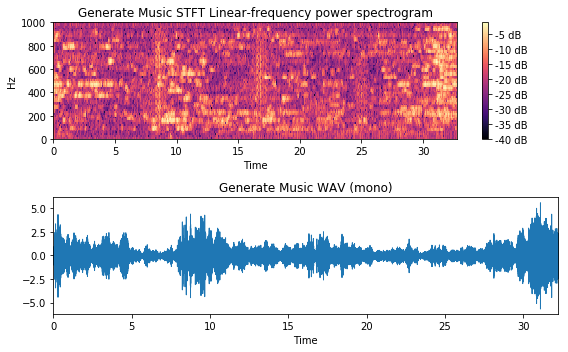

--------------------------------------------------------------------------------
Epoch 400 result
[1] result


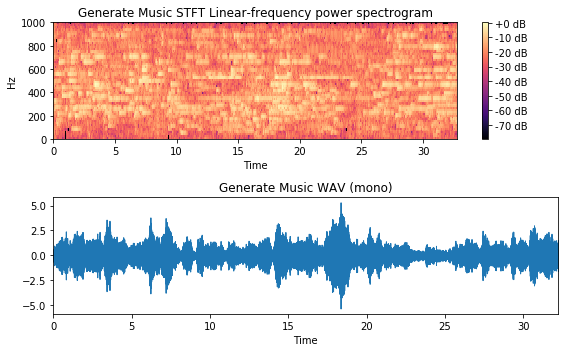

--------------------------------------------------------------------------------
Epoch 1000 result
[1] result


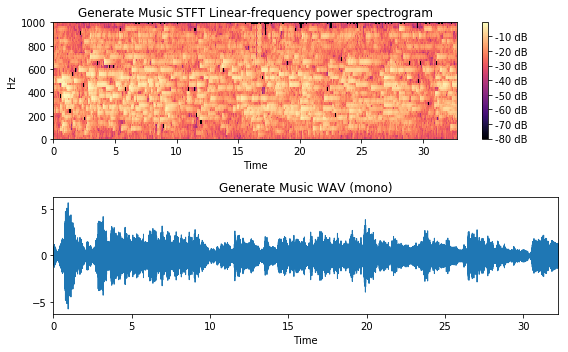

--------------------------------------------------------------------------------


In [4]:
for e in epochs:

    model = load_model(netD_name_fmt.format(e))
    gen_sepc2ch_img = model.predict(fixed_noise)
    
    gen_sepc2ch_img = gen_sepc2ch_img[6:7, :]
    print('Epoch {:d} result'.format(e))
    plot_stft_wave(gen_sepc2ch_img, 'Generate Music', sr=2000, n_hop=n_hop)
    
    print("="*80)